In [115]:
import skrub
from pathlib import Path
import pandas as pd
import sys
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from skrub import tabular_learner
from skrub import TableVectorizer
from datetime import datetime
import os
import json
import re 
import seaborn as sns
import  pingouin as pg

from sklearn.impute import KNNImputer

sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict, audit, plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived  = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived  = '/Users/alina/Desktop/MIT/code/data/output/derived_data'
audit_path = (Path(data_derived, 'audit'))
baseline_path = (Path(audit_path, 'baseline_data_prea'))

#os.listdir(data_root)

In [51]:
info_path = Path(data_root, "files")
treat_group_file = 'treatment_groups.csv'
trt_names = pd.read_csv(Path(data_derived, treat_group_file))

In [52]:
split_chars = "[0_]"
info_dict = {}
qsts = []

for item in os.listdir(info_path):
    if not item.startswith(".")  and not os.path.isdir(Path(info_path, item)):
        name = re.split(split_chars, item)[0]
        qsts.append(name)
        print(name)
        info_dict[name] = pd.read_csv(Path(info_path, item), usecols=['ElementName','DataType', 'ElementDescription'] )

debrief
debrief14
schoolhx
diagpsx
expect
cisp
health
masc
snap
scapijus
cbcl
pcrc
medse
ssrs
wiat
demgr
scid


In [53]:
qsts =['expect', 'masc', 'snap', 'wiat', 'demgr', 'cisp', 'ssrs', 'pcrc', 'cbcl']

In [54]:

split_chars = '_'
data_dict = {}
for item in os.listdir(baseline_path):
    if not item.startswith(".") and any([item.startswith(qst) for qst in qsts]) and not os.path.isdir(Path(baseline_path, item)):
        name = re.split(split_chars, item)[0]
        data_dict[name] = pd.read_csv(Path(baseline_path, item))

In [55]:
data_dict.keys()

dict_keys(['expect', 'masc', 'snap', 'wiat', 'demgr', 'cisp', 'ssrs', 'pcrc', 'cbcl'])

In [56]:
with open(Path(audit_path,'params' ,"audit_params.json"), "r") as f:
    params = json.load(f)
params.keys()

dict_keys(['missing_vals_code', 'cols_known2rem', 'family_mapping', 'simple_relation_mapping', 'dtype_dict', 'var_to_description', 'exclude_files_thr', 'cols_no_qst'])

In [57]:
params['cols_no_qst']

['src_subject_id',
 'relationship',
 'fam_relation',
 'simple_relation',
 'interview_age',
 'sex',
 'version_form',
 'assbdic',
 'actbdic']

In [58]:
relation_col = 'fam_relation'

In [59]:
cols2keep_stats = ['src_subject_id']
cols2keep_stats.append(relation_col)

cols2remove_stats = [ col for col in params['cols_no_qst'] if col not in cols2keep_stats]
cols2remove_stats

['relationship',
 'simple_relation',
 'interview_age',
 'sex',
 'version_form',
 'assbdic',
 'actbdic']

In [60]:
data_dict['snap']

,Unnamed: 0,src_subject_id,interview_age,sex,snap_adhd_1,snap_adhd_2,snap_adhd_3,snap_adhd_4,snap_adhd_5,snap_adhd_6,...,snahyimx,snaadhdt,snahit,snadbdx,assbdic,relationship,actbdic,version_form,simple_relation,fam_relation
0,8,P1002,120.0,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0.92,16.00,7.00,1.00,D,1,1,Parent,1.0,1.0
1,9,P1002,120.0,M,1.0,1.0,1.0,1.0,1.0,2.0,...,1.00,19.00,9.00,1.00,D,2,1,Parent,1.0,2.0
2,18,P1003,108.0,M,2.0,2.0,2.0,3.0,3.0,2.0,...,2.80,46.59,24.75,2.63,D,1,1,Parent,1.0,1.0
3,19,P1003,108.0,M,2.0,3.0,3.0,3.0,2.0,3.0,...,2.75,49.00,25.00,2.69,D,2,1,Parent,1.0,2.0
4,32,P1004,108.0,F,2.0,1.0,1.0,2.0,1.0,2.0,...,2.00,32.00,19.00,1.77,D,1,1,Parent,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,14336,P1830,84.0,M,3.0,3.0,3.0,3.0,3.0,3.0,...,2.67,49.00,24.00,2.38,D,5,1,Teacher,2.0,5.0
1460,14383,P1837,72.0,M,3.0,3.0,2.0,3.0,3.0,3.0,...,1.92,42.00,18.00,1.85,D,5,1,Teacher,2.0,5.0
1461,14397,P1839,72.0,M,2.0,2.0,2.0,3.0,1.0,3.0,...,2.67,39.00,23.00,2.38,D,5,1,Teacher,2.0,5.0
1462,14423,P1842,72.0,M,3.0,3.0,3.0,3.0,3.0,3.0,...,2.08,44.00,19.00,1.87,D,5,1,Teacher,2.0,5.0


In [61]:
test = data_dict['snap']
print([col for col in cols2keep_stats if col in test.columns])
test = test.drop(columns= cols2remove_stats)
print([col for col in cols2keep_stats if col in test.columns])
test = test.drop(columns='Unnamed: 0')

['src_subject_id', 'fam_relation']
['src_subject_id', 'fam_relation']


In [62]:
test = audit.set_dtypes_and_nan(test, info_dict['snap'], params['missing_vals_code'], params['dtype_dict'] ,cols_known_to_keep=relation_col )

Removing subject-unspecific columns ..  N =  0
[]
(1464, 51)
Setting dtypes...


In [63]:
print([col for col in cols2keep_stats if col in test.columns])

['src_subject_id', 'fam_relation']


In [64]:
summary_cols = np.concatenate(([col for col in test.columns if col.endswith('t')], cols2keep_stats))
not_summ_cols = np.concatenate(([col for col in test.columns if col not in summary_cols], cols2keep_stats))
print(summary_cols)

['snainatt' 'snahypat' 'snaimput' 'snaaddwt' 'snaoddt' 'snatotlt'
 'snaadhdt' 'snahit' 'src_subject_id' 'fam_relation']


In [65]:
test_long=  pd.melt(test, id_vars=["src_subject_id", relation_col], var_name="question", value_name="Score")
test_long['question'] = test_long["question"].astype(str)

test_long_summ=  pd.melt(test[summary_cols], id_vars=["src_subject_id", relation_col], var_name="question", value_name="Score")
test_long_summ['question'] = test_long_summ["question"].astype(str)

test_long_notsum=  pd.melt(test[not_summ_cols], id_vars=["src_subject_id", relation_col], var_name="question", value_name="Score")
test_long_notsum['question'] = test_long_notsum["question"].astype(str)

In [66]:
test_long_notsum = test_long_notsum.drop(columns= 'src_subject_id')

In [67]:
test_long.dtypes

src_subject_id     object
fam_relation      float64
question           object
Score             float64
dtype: object

In [68]:
params.keys()

dict_keys(['missing_vals_code', 'cols_known2rem', 'family_mapping', 'simple_relation_mapping', 'dtype_dict', 'var_to_description', 'exclude_files_thr', 'cols_no_qst'])

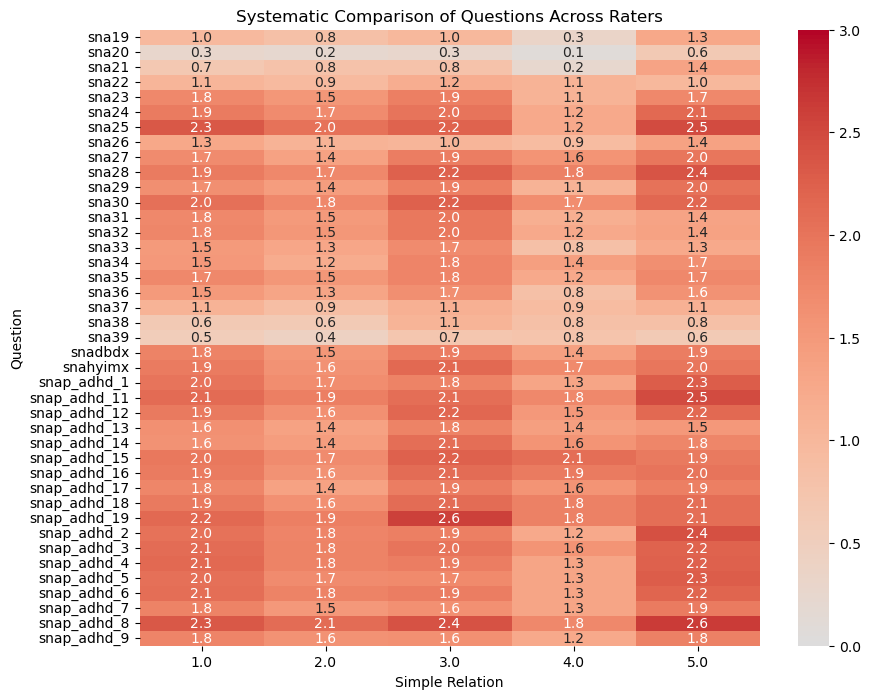

In [69]:


heatmap_data = test_long_notsum.pivot_table(
    index="question",  # Rows
    columns=relation_col,  # Columns
    values="Score",  # Values
    aggfunc="mean"  # Aggregation function
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", cbar=True, center=-0
, vmin = 0, vmax = 3)
plt.title("Systematic Comparison of Questions Across Raters")
plt.xlabel("Simple Relation")
plt.ylabel("Question")
plt.show()

In [70]:
test.keys()

Index(['src_subject_id', 'snap_adhd_1', 'snap_adhd_2', 'snap_adhd_3',
       'snap_adhd_4', 'snap_adhd_5', 'snap_adhd_6', 'snap_adhd_7',
       'snap_adhd_8', 'snap_adhd_9', 'snap_adhd_11', 'snap_adhd_12',
       'snap_adhd_13', 'snap_adhd_14', 'snap_adhd_15', 'snap_adhd_16',
       'snap_adhd_17', 'snap_adhd_18', 'snap_adhd_19', 'sna19', 'sna20',
       'sna21', 'sna22', 'sna23', 'sna24', 'sna25', 'sna26', 'sna27', 'sna28',
       'sna29', 'sna30', 'sna31', 'sna32', 'sna33', 'sna34', 'sna35', 'sna36',
       'sna37', 'sna38', 'sna39', 'snainatt', 'snahypat', 'snaimput',
       'snaaddwt', 'snaoddt', 'snatotlt', 'snahyimx', 'snaadhdt', 'snahit',
       'snadbdx', 'fam_relation'],
      dtype='object')

In [71]:
correlation_matrix = test.drop(columns='src_subject_id').corr()

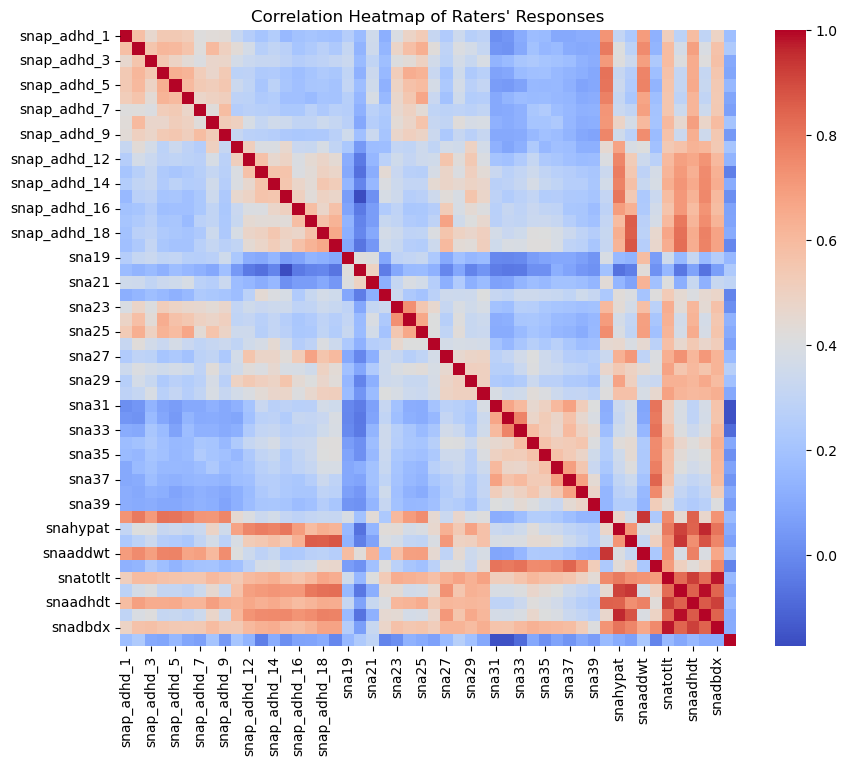

In [72]:
plt.figure(figsize=(10,8))

sns.heatmap(correlation_matrix, annot= False, cmap= 'coolwarm', cbar= True, square= True)

plt.title("Correlation Heatmap of Raters' Responses")
plt.show()

In [73]:
os.listdir(Path(data_derived, 'audit', 'baseline_data_prea'))

['_wiat.csv',
 'expect_baseline_data_prea.csv',
 'masc_baseline_data_prea.csv',
 '.DS_Store',
 'snap_baseline_data_prea.csv',
 '_snap.csv',
 'wiat_baseline_data_prea.csv',
 'demgr_baseline_data_prea.csv',
 '_ssrs.csv',
 '_pcrc.csv',
 'cisp_baseline_data_prea.csv',
 '_cisp.csv',
 'ssrs_baseline_data_prea.csv',
 '_masc.csv',
 'pcrc_baseline_data_prea.csv',
 '_demgr.csv',
 '_cbcl.csv',
 'cbcl_baseline_data_prea.csv',
 '_expect.csv']

In [74]:
ssrs = pd.read_csv(Path(audit_path, 'ssrs_baseline_p_t_dup_prea.csv'))
snap = pd.read_csv(Path(audit_path,'snap_baseline_p_t_dup_prea.csv'))

data_dict_p_t = dict(zip( ['snap', 'ssrs'], [snap, ssrs]))

cols2drop_p_t =['Unnamed: 0', 'src_subject_id', 'sex']

for qst , data in data_dict_p_t.items():
    data_dict_p_t[qst] = data.drop(columns=cols2drop_p_t)

In [75]:
data_dict_p_t

{'snap':      snap_adhd_1_p  snap_adhd_2_p  snap_adhd_3_p  snap_adhd_4_p  \
 0              1.0            1.0            1.0            1.0   
 1              1.0            1.0            1.0            1.0   
 2              2.0            2.0            2.0            3.0   
 3              2.0            3.0            3.0            3.0   
 4              2.0            1.0            1.0            2.0   
 ..             ...            ...            ...            ...   
 903            2.0            2.0            2.0            1.0   
 904            2.0            2.0            2.0            3.0   
 905            1.0            2.0            1.0            3.0   
 906            3.0            3.0            3.0            3.0   
 907            2.0            2.0            2.0            2.0   
 
      snap_adhd_5_p  snap_adhd_6_p  snap_adhd_7_p  snap_adhd_8_p  \
 0              1.0            1.0            1.0            1.0   
 1              1.0            2.0    

In [76]:
snap_test = snap.drop(columns=['Unnamed: 0', 'src_subject_id', 'sex'])

In [123]:
params['col2drop_stats'] = set(['Unnamed: 0', 'src_subject_id', 'sex'])

In [124]:
params['col2drop_stats'].update(params['cols_no_qst'])

In [126]:
params['col2drop_stats'].update(['simple_relation'])

In [127]:
params['col2drop_stats']

{'Unnamed: 0',
 'actbdic',
 'assbdic',
 'fam_relation',
 'interview_age',
 'relationship',
 'sex',
 'simple_relation',
 'src_subject_id',
 'version_form'}

In [77]:

corr_p_t = {qst : data.corr() for qst, data in data_dict_p_t.items()}

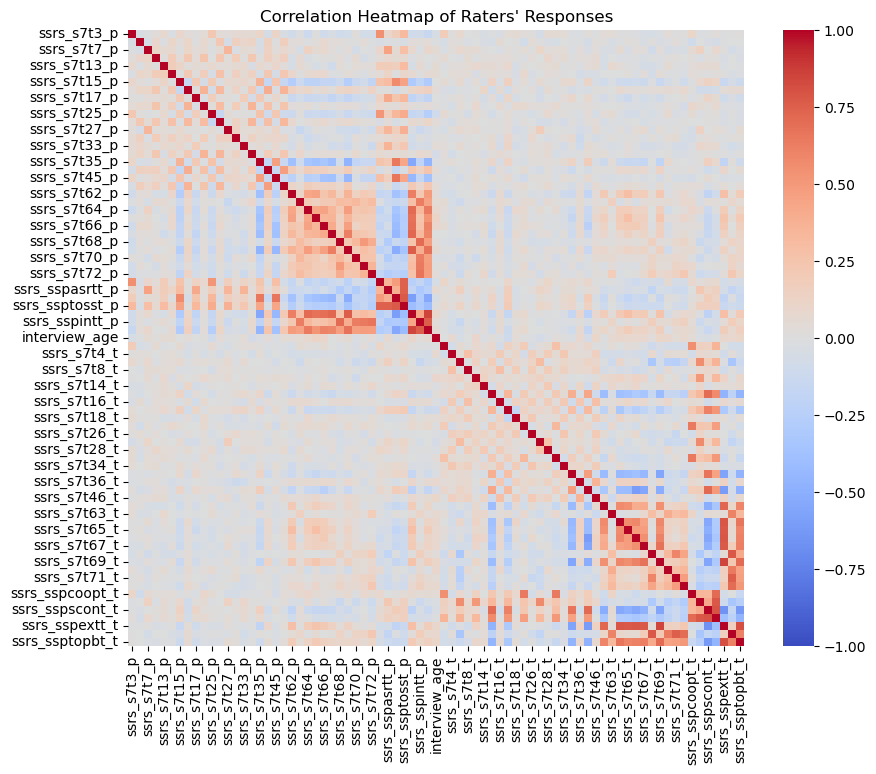

In [78]:
plt.figure(figsize=(10,8))

sns.heatmap(corr_p_t['ssrs'], annot= False, cmap= 'coolwarm', cbar= True, square= True, vmin = -1, vmax=  1)

plt.title("Correlation Heatmap of Raters' Responses")
plt.show()

In [79]:
parent_columns = [col for col in snap_test.columns if col.endswith('_p')]
teacher_columns = [col for col in snap_test.columns if col.endswith('_t')]

# Step 2: Match corresponding parent and teacher questions by prefix
# Assume the prefix before '_p' or '_t' is the question identifier
parent_to_teacher = {
    p: t for p, t in zip(parent_columns, teacher_columns) if p[:-2] == t[:-2]
}

# Step 3: Compute correlations
correlations = {
    question: snap_test[parent_to_teacher[question]].corr(snap_test[question])
    for question in parent_columns
}

# Step 4: Convert results into a DataFrame for visualization
correlation_df = pd.DataFrame(list(correlations.items()), columns=["Question", "Correlation"])

# Display the correlation matrix
print(correlation_df)

           Question  Correlation
0     snap_adhd_1_p     0.214725
1     snap_adhd_2_p     0.100670
2     snap_adhd_3_p     0.086684
3     snap_adhd_4_p     0.191153
4     snap_adhd_5_p     0.178257
5     snap_adhd_6_p     0.228684
6     snap_adhd_7_p     0.266111
7     snap_adhd_8_p    -0.014894
8     snap_adhd_9_p     0.072466
9    snap_adhd_11_p     0.090421
10   snap_adhd_12_p     0.218856
11   snap_adhd_13_p     0.217731
12   snap_adhd_14_p     0.115557
13   snap_adhd_15_p     0.218324
14   snap_adhd_16_p     0.189516
15   snap_adhd_17_p     0.240315
16   snap_adhd_18_p     0.200801
17   snap_adhd_19_p     0.190996
18     snap_sna19_p     0.104862
19     snap_sna20_p     0.140056
20     snap_sna21_p     0.135745
21     snap_sna22_p     0.223983
22     snap_sna23_p     0.122796
23     snap_sna24_p     0.161801
24     snap_sna25_p     0.159438
25     snap_sna26_p     0.083075
26     snap_sna27_p     0.331906
27     snap_sna28_p     0.173214
28     snap_sna29_p     0.126221
29     sna

1. drop cols to drop execpt src subject id 
2. extract the data fam relation wise 
3. ensure same subject are present in both 
4. remove column src subject id 
5. corr

In [80]:
cols2remove_stats

['relationship',
 'simple_relation',
 'interview_age',
 'sex',
 'version_form',
 'assbdic',
 'actbdic']

In [81]:
for qst, data in data_dict.items():
    print(qst, "simple", data.simple_relation.value_counts())
    print(qst, "fam" , data.fam_relation.value_counts())

expect simple simple_relation
1    870
4     47
Name: count, dtype: int64
expect fam fam_relation
1    528
2    342
3     29
4     12
7      6
Name: count, dtype: int64
masc simple simple_relation
0    575
Name: count, dtype: int64
masc fam fam_relation
0    575
Name: count, dtype: int64
snap simple simple_relation
1.0    870
2.0    546
4.0     41
Name: count, dtype: int64
snap fam fam_relation
5.0    546
1.0    529
2.0    341
3.0     29
4.0     12
Name: count, dtype: int64
wiat simple simple_relation
0    579
Name: count, dtype: int64
wiat fam fam_relation
0    579
Name: count, dtype: int64
demgr simple Series([], Name: count, dtype: int64)
demgr fam Series([], Name: count, dtype: int64)
cisp simple Series([], Name: count, dtype: int64)
cisp fam Series([], Name: count, dtype: int64)
ssrs simple simple_relation
1    889
2    546
4     40
Name: count, dtype: int64
ssrs fam fam_relation
5    546
1    542
2    347
3     26
4     10
7      4
Name: count, dtype: int64
pcrc simple simple_rel

In [82]:
relation_col = 'relationship'
qst = 'expect'

save = True

title_dict = {"relationship" : 'Biological Mother vs Biological Father Correlation by Question ', 
              "fam_relation" : "Mother Figure vs Father Figure Correlation by Question ", 
              "simple_relation" : "Parent vs Teacher Correlation by Question "}

In [83]:

cols2remove_corr_relation= ['Unnamed: 0',  'fam_relation']
data_m = data_dict[qst][data_dict[qst][relation_col] == 1].drop(columns = cols2remove_corr_relation)
data_f = data_dict[qst][data_dict[qst][relation_col] == 2].drop(columns = cols2remove_corr_relation)


In [84]:
print((data_f.src_subject_id.value_counts() > 1).sum(), (data_m.src_subject_id.value_counts() > 1).sum())

0 0


In [85]:
snap_m_drop = audit.remove_duplicates(data_m, 'src_subject_id', keep ='first') # remove duplicated to set the index on the subject ids 
snap_f_drop = audit.remove_duplicates(data_f, 'src_subject_id', keep = 'first')

In [86]:
missing_subj_ = [sub for sub in data_f['src_subject_id'].tolist() if sub not in data_m['src_subject_id'].tolist()  ]
missing_subj__ = [sub for sub in data_m['src_subject_id'].tolist() if sub not in data_m['src_subject_id'].tolist()  ]
missing_subj = set(missing_subj_)
missing_subj.update(missing_subj__)
data_f = data_f[~data_f["src_subject_id"].isin(missing_subj)]
data_m = data_m[~data_m["src_subject_id"].isin(missing_subj)]

In [87]:
data_f.set_index('src_subject_id', inplace= True) # make sure to have matching indices for the correlation computation 
data_m.set_index('src_subject_id',  inplace= True)

In [88]:
snap_cols = [col for col in data_m.columns if col in data_f.columns and col not in cols2remove_stats ]
snap_cols

['exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6', 'exptott']

In [89]:
data_f

,interview_age,sex,assbdic,relationship,actbdic,exp1,exp2,exp3,exp4,exp5,exp6,exptott,simple_relation
src_subject_id,,,,,,,,,,,,,
P1002,120,M,D,2,1,7,2.0,4.0,7.0,7.0,2.0,29.0,1
P1003,108,M,D,2,1,3,9.0,9.0,10.0,5.0,8.0,44.0,1
P1006,108,M,D,2,1,8,6.0,5.0,4.0,4.0,3.0,30.0,1
P1007,108,M,D,2,1,4,3.0,3.0,7.0,5.0,3.0,25.0,1
P1009,108,M,D,2,1,5,5.0,5.0,5.0,5.0,3.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
P1823,84,M,D,2,1,5,6.0,6.0,6.0,6.0,6.0,35.0,1
P1825,84,M,D,2,1,5,4.0,2.0,4.0,2.0,2.0,19.0,1
P1828,84,M,D,2,1,9,8.0,7.0,5.0,4.0,5.0,38.0,1


In [90]:
difference = {
    qst: data_m[qst].mean() - data_f[qst].mean()
    for qst in snap_cols
}
difference

{'exp1': 0.4731613146247291,
 'exp2': 1.2748494179293957,
 'exp3': 0.38572238572238593,
 'exp4': 0.40564083247010085,
 'exp5': 0.29762689518787067,
 'exp6': 0.14257463037950835,
 'exptott': 2.9873716922497415}

In [91]:
data_f.index.equals(data_m.index)


False

In [92]:
correlations = {
    qst: data_m[qst].corr(data_f[qst])
    for qst in snap_cols
}
print(correlations)
correlation_df = pd.DataFrame(list(correlations.items()), columns=["Question", "Correlation"])

# Display the correlation matrix
print(correlation_df)

{'exp1': 0.42480547289827375, 'exp2': 0.38411202246296966, 'exp3': 0.41643360845298005, 'exp4': 0.37674220743669556, 'exp5': 0.3453881349266044, 'exp6': 0.41045439868486217, 'exptott': 0.48528646166338546}
  Question  Correlation
0     exp1     0.424805
1     exp2     0.384112
2     exp3     0.416434
3     exp4     0.376742
4     exp5     0.345388
5     exp6     0.410454
6  exptott     0.485286


In [93]:
save_path = "/Users/alina/Desktop/MIT/code/data/output/figures/audit/correlation"

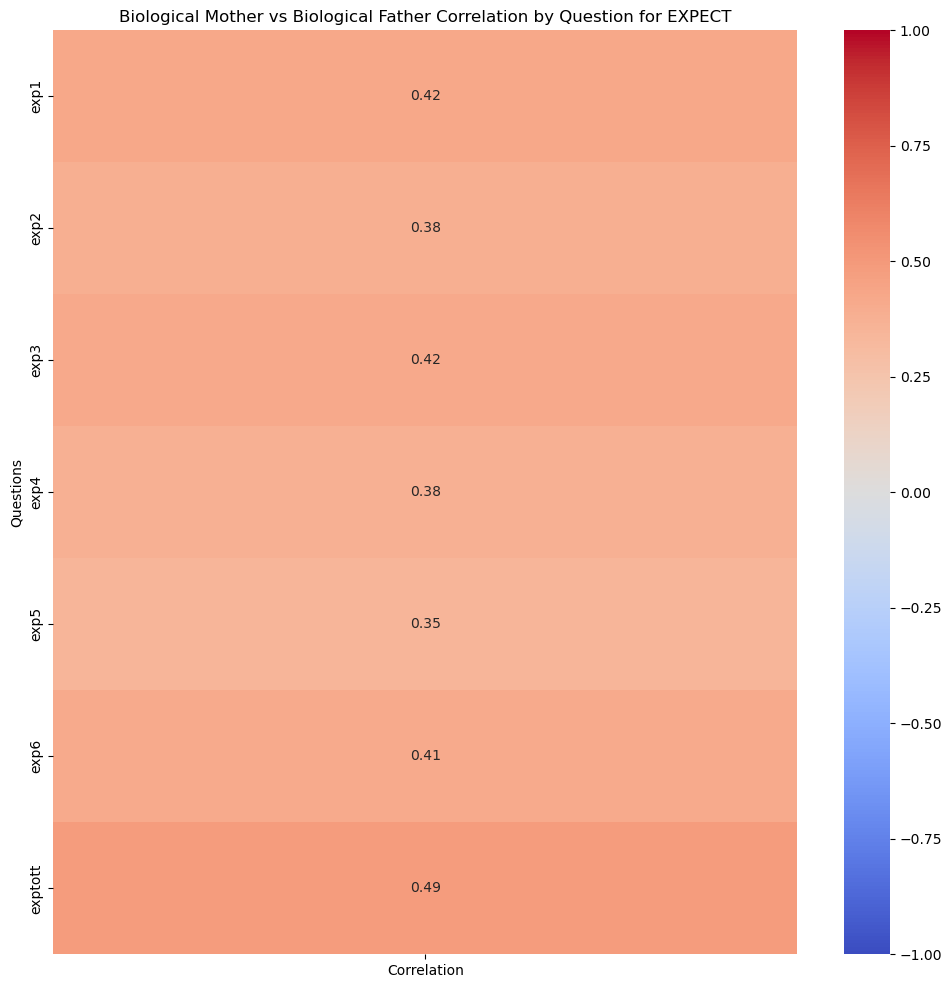

In [94]:
correlation_df = pd.DataFrame(list(correlations.items()), columns=["Question", "Correlation"])

# Step 3: Reshape Data for Heatmap
# This step is optional, as we have a one-dimensional correlation matrix
correlation_matrix = correlation_df.set_index("Question")

# Step 4: Plot the Heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, vmin = -1, vmax=1)
plt.title(title_dict[relation_col] + 'for {}'.format(qst.upper()))
#plt.xlabel("Correlation")
plt.ylabel("Questions")

if save : 
    plt.savefig(Path(save_path, '{}_{}_corr.png'.format(qst, relation_col)) )
plt.show()


In [95]:
data_dict.keys()

dict_keys(['expect', 'masc', 'snap', 'wiat', 'demgr', 'cisp', 'ssrs', 'pcrc', 'cbcl'])

In [96]:
info_dict['snap'][ info_dict['snap']['ElementName'] == 'sna39']

,ElementName,DataType,ElementDescription
51,sna39,Integer,Swore or used obscene language


### CCC

In [202]:
data_dict_fam_imp = {}

In [203]:
params.keys()

dict_keys(['missing_vals_code', 'cols_known2rem', 'family_mapping', 'simple_relation_mapping', 'dtype_dict', 'var_to_description', 'exclude_files_thr', 'cols_no_qst', 'col2drop_stats'])

In [204]:
params['col2drop_stats']

{'Unnamed: 0',
 'actbdic',
 'assbdic',
 'fam_relation',
 'interview_age',
 'relationship',
 'sex',
 'simple_relation',
 'src_subject_id',
 'version_form'}

In [205]:



for qst in ['snap', 'ssrs']:
    impute_col = [col for col in data_dict[qst].columns if col not in params['col2drop_stats']]
    non_numeric_cols = [col for col in data_dict[qst].columns if col not in impute_col]
    print(impute_col)
    imputer = KNNImputer(n_neighbors=5)
    data_imp =  pd.DataFrame(imputer.fit_transform(data_dict[qst][impute_col]), columns=impute_col)
    print(impute_col)
    print(non_numeric_cols)
    data_imp_concat = pd.concat((data_imp, data_dict[qst][non_numeric_cols]), axis = 1)
    data_dict_fam_imp['{}_imp'.format(qst)] =data_imp_concat



['snap_adhd_1', 'snap_adhd_2', 'snap_adhd_3', 'snap_adhd_4', 'snap_adhd_5', 'snap_adhd_6', 'snap_adhd_7', 'snap_adhd_8', 'snap_adhd_9', 'snap_adhd_11', 'snap_adhd_12', 'snap_adhd_13', 'snap_adhd_14', 'snap_adhd_15', 'snap_adhd_16', 'snap_adhd_17', 'snap_adhd_18', 'snap_adhd_19', 'sna19', 'sna20', 'sna21', 'sna22', 'sna23', 'sna24', 'sna25', 'sna26', 'sna27', 'sna28', 'sna29', 'sna30', 'sna31', 'sna32', 'sna33', 'sna34', 'sna35', 'sna36', 'sna37', 'sna38', 'sna39', 'snainatt', 'snahypat', 'snaimput', 'snaaddwt', 'snaoddt', 'snatotlt', 'snahyimx', 'snaadhdt', 'snahit', 'snadbdx']
['snap_adhd_1', 'snap_adhd_2', 'snap_adhd_3', 'snap_adhd_4', 'snap_adhd_5', 'snap_adhd_6', 'snap_adhd_7', 'snap_adhd_8', 'snap_adhd_9', 'snap_adhd_11', 'snap_adhd_12', 'snap_adhd_13', 'snap_adhd_14', 'snap_adhd_15', 'snap_adhd_16', 'snap_adhd_17', 'snap_adhd_18', 'snap_adhd_19', 'sna19', 'sna20', 'sna21', 'sna22', 'sna23', 'sna24', 'sna25', 'sna26', 'sna27', 'sna28', 'sna29', 'sna30', 'sna31', 'sna32', 'sna33', 

In [206]:
data_dict_fam_imp['snap_imp']['assbdic'].unique()

array(['D'], dtype=object)

In [207]:
data_dict_fam_imp['snap_imp'].dropna().shape

(1457, 59)

In [208]:
map_dict = {   
    'fam_relation' : {1: 'm_fig', 
            2: 'f_fig'},

    'simple_relation' : {1: 'm_bio',
                        2: 'f_bio'}}

extract only rates to be considered and strore in seperate dataframe 

In [209]:


for qst in ['snap_imp', 'ssrs_imp']:
    for rel in ['fam_relation', 'simple_relation']:
            data =  data_dict_fam_imp[qst][(data_dict_fam_imp[qst][rel] ==  1)| ( data_dict_fam_imp[qst][rel] ==  2)]
            data_dict_fam_imp['{}_{}'.format(qst, rel)] = data
        
    

In [210]:
data_dict_fam_imp.keys()

dict_keys(['snap_imp', 'ssrs_imp', 'snap_imp_fam_relation', 'snap_imp_simple_relation', 'ssrs_imp_fam_relation', 'ssrs_imp_simple_relation'])

## Clean this up

In [266]:

col2keep = ['src_subject_id', 'fam_relation', 'relationship', 'simple_relation']
test = data_dict_fam_imp['snap_imp_fam_relation'].drop(columns = [col for col in params['col2drop_stats'] if col not in col2keep])
cols_ccc = [col for col in data_dict_fam_imp['snap_imp_fam_relation'].drop(columns = [  col for col in params['col2drop_stats'] ] ).columns ]
print(test.keys())
print(cols_ccc)

long_df = test.melt(
    id_vars=["src_subject_id", 'fam_relation', 'simple_relation', 'relationship'],  # Columns to keep
    var_name="snap_question_relation",  # New column for variable names
    value_name="rating"  # New column for values
)

ssrs_ccc =  data_dict_fam_imp['ssrs_imp_fam_relation'].drop(columns = [col for col in params['col2drop_stats'] if col not in col2keep])
cols_ccc_ssrs = [col for col in data_dict_fam_imp['ssrs_imp_fam_relation'].drop(columns = [  col for col in params['col2drop_stats'] ] ).columns ]


Index(['snap_adhd_1', 'snap_adhd_2', 'snap_adhd_3', 'snap_adhd_4',
       'snap_adhd_5', 'snap_adhd_6', 'snap_adhd_7', 'snap_adhd_8',
       'snap_adhd_9', 'snap_adhd_11', 'snap_adhd_12', 'snap_adhd_13',
       'snap_adhd_14', 'snap_adhd_15', 'snap_adhd_16', 'snap_adhd_17',
       'snap_adhd_18', 'snap_adhd_19', 'sna19', 'sna20', 'sna21', 'sna22',
       'sna23', 'sna24', 'sna25', 'sna26', 'sna27', 'sna28', 'sna29', 'sna30',
       'sna31', 'sna32', 'sna33', 'sna34', 'sna35', 'sna36', 'sna37', 'sna38',
       'sna39', 'snainatt', 'snahypat', 'snaimput', 'snaaddwt', 'snaoddt',
       'snatotlt', 'snahyimx', 'snaadhdt', 'snahit', 'snadbdx',
       'src_subject_id', 'relationship', 'simple_relation', 'fam_relation'],
      dtype='object')
['snap_adhd_1', 'snap_adhd_2', 'snap_adhd_3', 'snap_adhd_4', 'snap_adhd_5', 'snap_adhd_6', 'snap_adhd_7', 'snap_adhd_8', 'snap_adhd_9', 'snap_adhd_11', 'snap_adhd_12', 'snap_adhd_13', 'snap_adhd_14', 'snap_adhd_15', 'snap_adhd_16', 'snap_adhd_17', 'snap_

In [273]:
ccc_snap = {col : pg.intraclass_corr(data = test, targets="src_subject_id", raters="fam_relation", ratings=col, nan_policy="omit") for col in cols_ccc} 


In [274]:
ccc_ssrs = {col : pg.intraclass_corr(data = ssrs_ccc, targets="src_subject_id", raters="fam_relation", ratings=col, nan_policy="omit") for col in cols_ccc_ssrs} 


In [269]:
def plot_ccc(ccc):
    consolidated_results = []
    for question, df in ccc.items():
        icc3_row = df[df["Type"] == "ICC3"].iloc[0]  # Extract the ICC3 row
        lower_ci, upper_ci = icc3_row["CI95%"][0], icc3_row["CI95%"][1]
        consolidated_results.append({
            "Question": question,
            "ICC": icc3_row["ICC"],
            "Lower_CI": lower_ci,
            "Upper_CI": upper_ci,
            "pval": icc3_row["pval"]
        })

    # Create a DataFrame
    data = pd.DataFrame(consolidated_results)

    # Step 2: Plot the results
    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        data["Question"], data["ICC"],
        color=["green" if x >= 0.75 else "blue" if x >= 0.50 else "orange" if x >= 0.30 else "red" for x in data["ICC"]],
        alpha=0.8
    )

    # Add error bars for confidence intervals
    plt.errorbar(
        data["Question"], data["ICC"],
        yerr=[data["ICC"] - data["Lower_CI"], data["Upper_CI"] - data["ICC"]],
        fmt="none", capsize=5, color="black"
    )

    # Add p-value annotations
    for i, row in data.iterrows():
        plt.text(i, row["ICC"] + 0.05, f"p={row['pval']:.2e}", ha="center", fontsize=10)

    # Add labels and formatting
    plt.title("ICC3 Values per Question with Confidence Intervals", fontsize=14)
    plt.xlabel("Questions", fontsize=12)
    plt.ylabel("ICC Value", fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    plt.show()


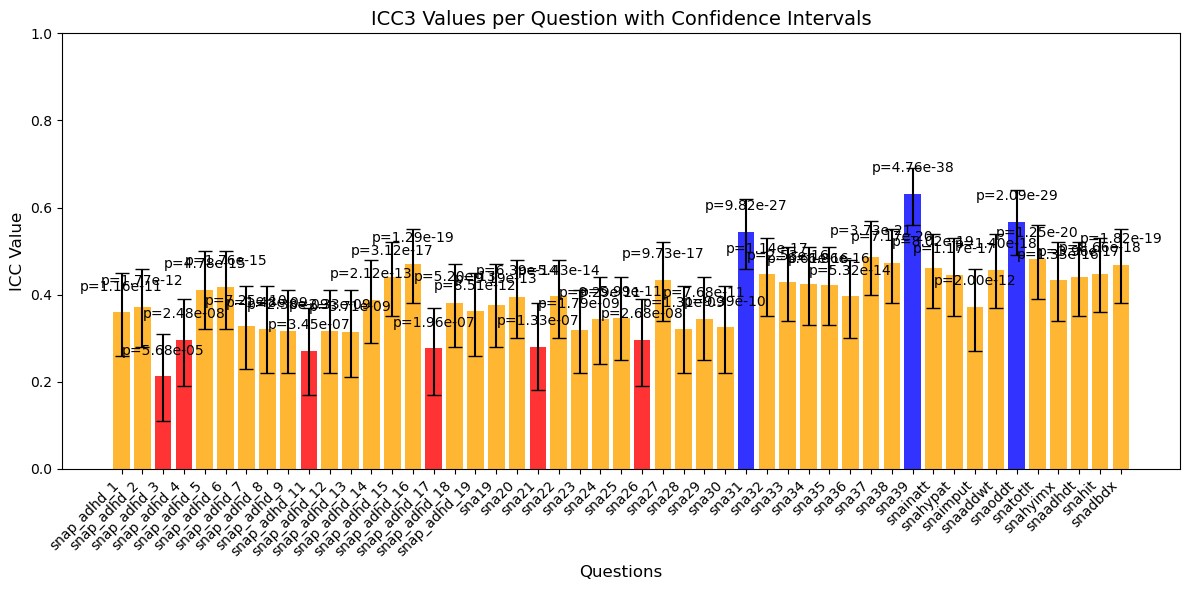

In [275]:
plot_ccc(ccc_snap)

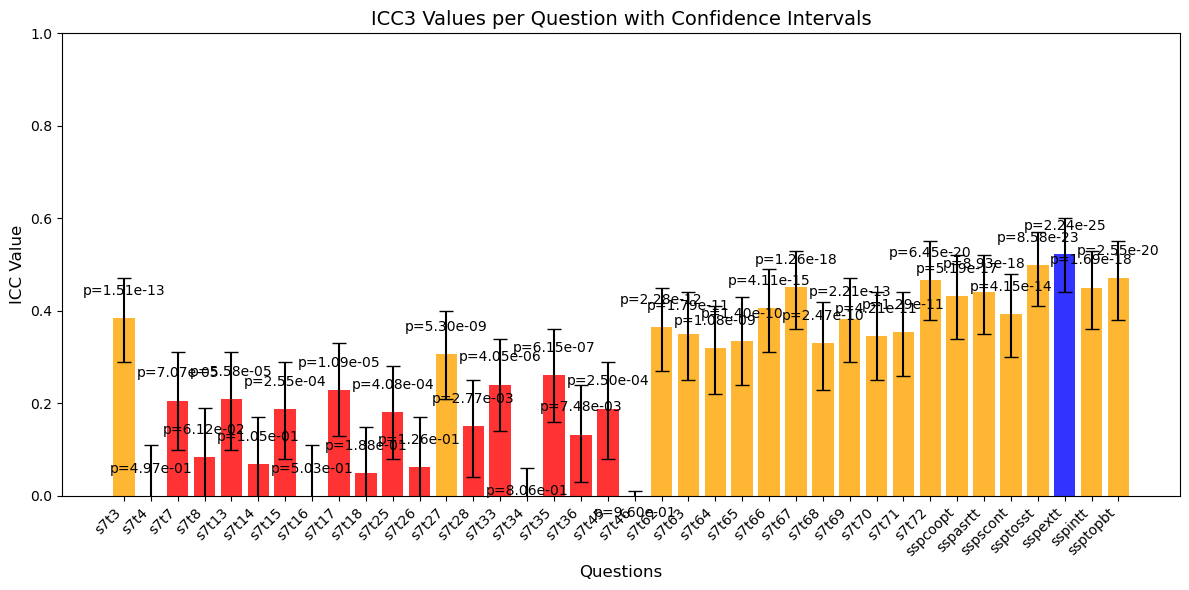

In [276]:
plot_ccc(ccc_ssrs)